Postavljanje okruženja

In [1]:
!pip install pandas openpyxl
!pip install pmdarima
!pip install pandas matplotlib statsmodels numpy scikit-learn
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings
from sklearn.model_selection import TimeSeriesSplit
from google.colab import drive
import matplotlib.dates as mdates
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Diplomski/diplomski/datasets/apple/Apple_historical_data.csv'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00
Mounted at /content/drive


Postavljanje dataseta:

In [2]:
data = pd.read_csv(file_path)

features_to_shift = [
  "yesterday_price"
]

data['yesterday_price'] = data['Adj_Close']
data[features_to_shift] = data[features_to_shift].shift(1)
data['price_diff'] = data['yesterday_price'] -  data['Adj_Close']

data = data[(data['Date'] >= '2015-01-01') & (data['Date'] <= '2020-01-01')]
features_to_keep = ["Date","Adj_Close", 'yesterday_price', 'price_diff']
data = data[features_to_keep]
data = data.reset_index(drop=True)
data

,Date,Adj_Close,yesterday_price,price_diff
0,2015-01-02,24.435265,24.669943,0.234678
1,2015-01-05,23.746889,24.435265,0.688376
2,2015-01-06,23.749128,23.746889,-0.002239
3,2015-01-07,24.082130,23.749128,-0.333002
4,2015-01-08,25.007435,24.082130,-0.925305
...,...,...,...,...
1253,2019-12-24,69.147995,69.082321,-0.065674
1254,2019-12-26,70.519913,69.147995,-1.371918
1255,2019-12-27,70.493164,70.519913,0.026749
1256,2019-12-30,70.911545,70.493164,-0.418381


Augmented Dickey–Fuller test:
* Pomaže u određivanju parametra d

In [3]:
result = adfuller(data['Adj_Close'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: 1.096595465020727
p-value: 0.9951874612604672
Critical Values:
	1%: -3.4356006420838963
	5%: -2.8638586845641063
	10%: -2.5680044958343604


Diferenciramo cijene

In [4]:
# Take the first difference
data['Adj_Close_diff'] = data['Adj_Close'].diff()
data.dropna(inplace=True)

Ponavljamo Augmented Dickey–Fuller test s diferenciranim vrijednostima

In [5]:
result = adfuller(data['Adj_Close_diff'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -10.331489760245969
p-value: 2.834807886217877e-18
Critical Values:
	1%: -3.4356006420838963
	5%: -2.8638586845641063
	10%: -2.5680044958343604


ACF i PACF:
* Pomaže u određivanju parametra p i q

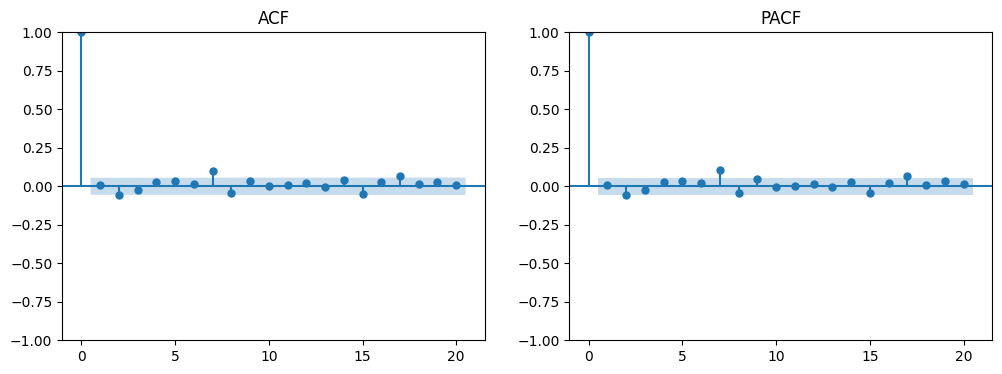

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(data['Adj_Close_diff'], lags=20, ax=ax1)
ax1.set_title('ACF')
plot_pacf(data['Adj_Close_diff'], lags=20, ax=ax2)
ax2.set_title('PACF')

plt.show()

Auto-ARIMA funkcija koja pronalazi optimalne p,q,d vrijednosti

In [7]:
stepwise_fit = auto_arima(data['Adj_Close'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2234.636, Time=8.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2233.322, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2235.235, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2235.223, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2236.552, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2236.953, Time=3.83 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 15.107 seconds


Vraćamo originalni dataset

In [8]:
data = pd.read_csv(file_path)

features_to_shift = [
  "yesterday_price"
]

data['yesterday_price'] = data['Adj_Close']
data[features_to_shift] = data[features_to_shift].shift(1)
data['price_diff'] = data['yesterday_price'] -  data['Adj_Close']

data = data[(data['Date'] >= '2015-01-01') & (data['Date'] <= '2020-01-01')]
features_to_keep = ["Date","Adj_Close", 'yesterday_price', 'price_diff']
data = data[features_to_keep]
data = data.reset_index(drop=True)
data

,Date,Adj_Close,yesterday_price,price_diff
0,2015-01-02,24.435265,24.669943,0.234678
1,2015-01-05,23.746889,24.435265,0.688376
2,2015-01-06,23.749128,23.746889,-0.002239
3,2015-01-07,24.082130,23.749128,-0.333002
4,2015-01-08,25.007435,24.082130,-0.925305
...,...,...,...,...
1253,2019-12-24,69.147995,69.082321,-0.065674
1254,2019-12-26,70.519913,69.147995,-1.371918
1255,2019-12-27,70.493164,70.519913,0.026749
1256,2019-12-30,70.911545,70.493164,-0.418381


# Walk forward validation
Time-series algoritmi rade na način da predviđaju buduću cijenu na temelju prošlih. Tu predviđenu cijenu spremamo u polje te ponavljamo isti postupak za idući dan itd...

Na kraju se uspoređuju stvarne cijene i predviđene i računamo:
*   MAE - Mean Absolute Error
*   MSE - Mean Squared Error
*  RMSE - Root Mean Squared Error
*   MAPE - Mean Absolute Percentage Error

Postavljnaje parametara ARIMA modela:
* Pozivamo onda funkciju walk_forward_validation kako bismo dobili previđene cijene

In [9]:
def walk_forward_validation(data, train_size, p, d, q):
    actual_values = []
    predicted_values = []
    rmse_values = []
    for i in range(train_size, len(data)):
        train_data = data.iloc[:i]
        test_data = data.iloc[i:i+1]
        model = ARIMA(train_data['Adj_Close'].values, order=(p, d, q))
        model_fit = model.fit()
        model.initialize_approximate_diffuse()
        forecast = model_fit.forecast(steps=1)[0]
        actual = test_data['price_diff'].values[0]
        actual_values.append(test_data['price_diff'].values[0])
        prediction = test_data['yesterday_price'].values[0] - forecast
        prediction = [prediction]
        actual = [actual]
        predicted_values.append(prediction)
        mse = mean_squared_error(actual, prediction)
        rmse = np.sqrt(mse)
        rmse_values.append(rmse)

    return predicted_values, actual_values , rmse_values


warnings.filterwarnings("ignore")

train_size = int(len(data) * 0.8)

p = 3
d = 1
q = 3

predicted_values, actual_values, rmse_values = walk_forward_validation(data, train_size, p, d, q)

Grafički prikaz

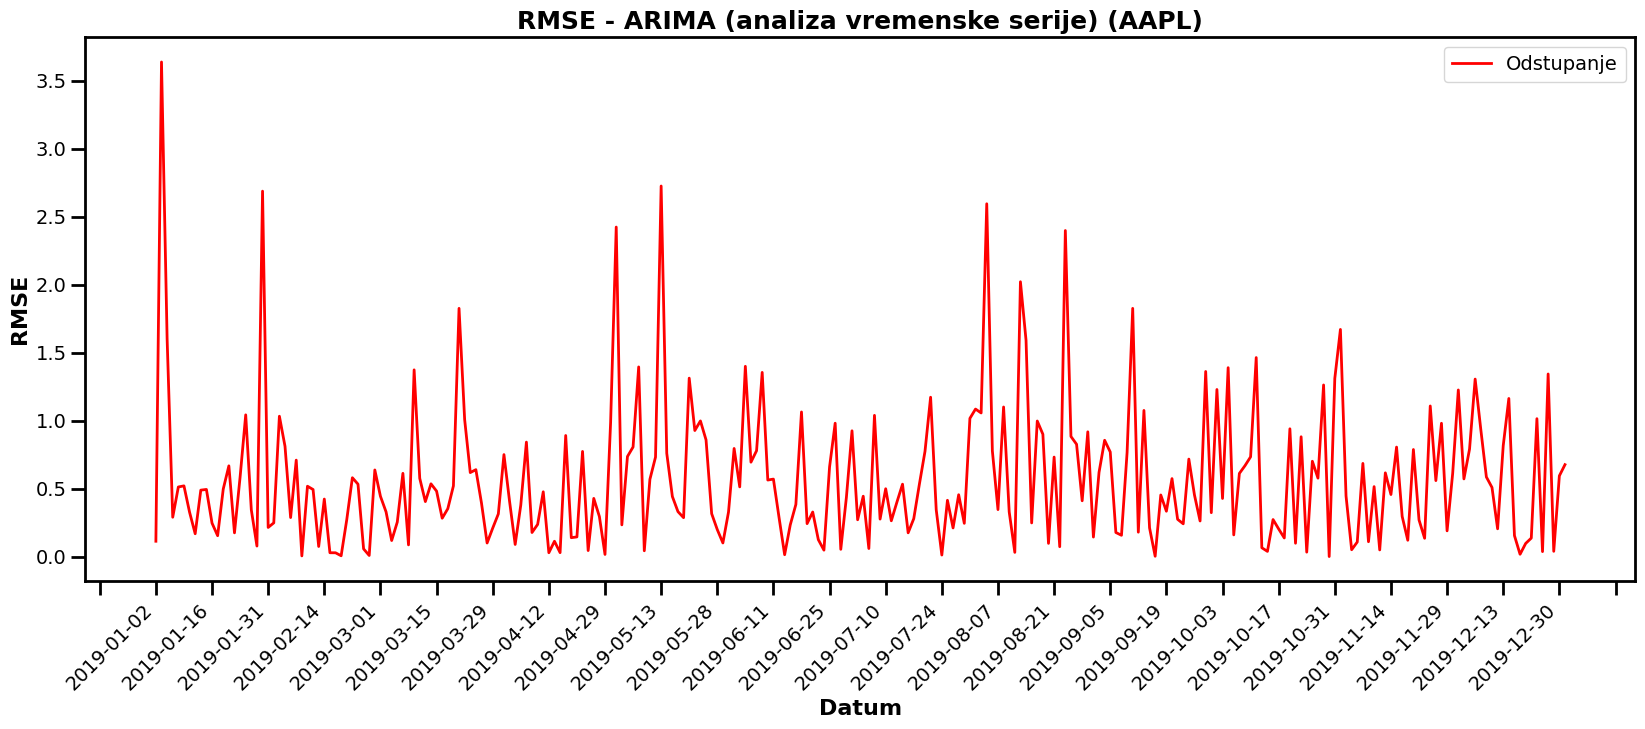

In [10]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot RMSE values with increased line thickness
plt.plot(plot_data["Date"], rmse_values, label='Odstupanje', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('RMSE', fontsize=16, fontweight='bold')
plt.title('RMSE - ARIMA (analiza vremenske serije) (AAPL)', fontsize=18, fontweight='bold')

# Customize the legend to make the label fatter and more prominent
plt.legend(fontsize=14, loc='best',frameon=True)

plt.show()


In [11]:
excel = {
    'Date': plot_data["Date"],
    'RMSE': rmse_values
}
df = pd.DataFrame(excel)

# Export to an Excel file
excel_file_path = 'ARIMA_time_series_GOOG_rmse_values.xlsx'
df.to_excel(excel_file_path, index=False)

mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
print(rmse)

0.788908728895613


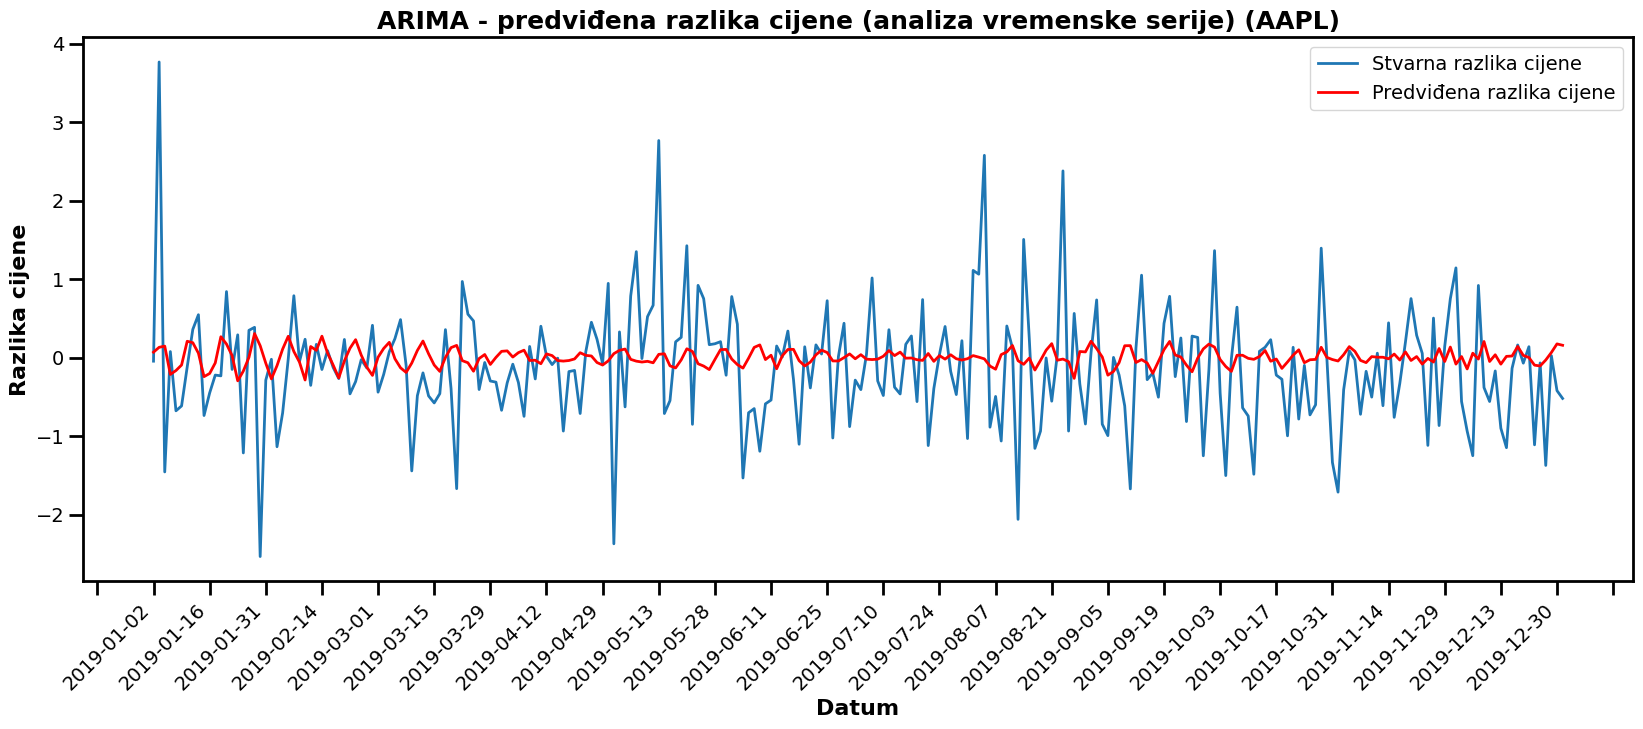

In [12]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot actual and predicted price differences with increased line thickness
plt.plot(plot_data["Date"], actual_values, label='Stvarna razlika cijene', linewidth=2)
plt.plot(plot_data["Date"], predicted_values, label='Predviđena razlika cijene', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Razlika cijene', fontsize=16, fontweight='bold')
plt.title('ARIMA - predviđena razlika cijene (analiza vremenske serije) (AAPL)', fontsize=18, fontweight='bold')

# Customize the legend as requested
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


In [13]:
extracted_values = [sublist[0] for sublist in predicted_values]

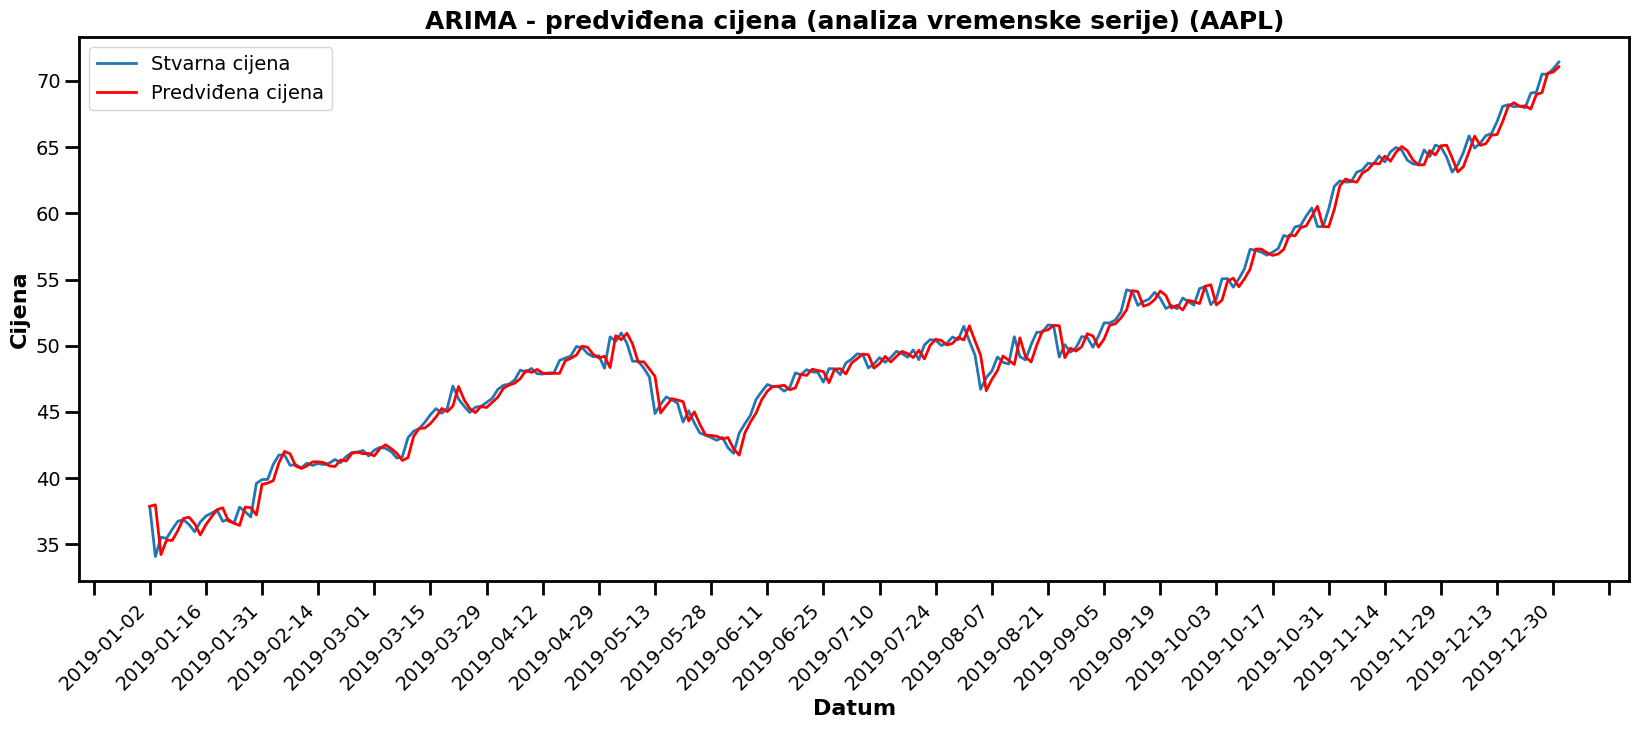

In [14]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plot_data["predicted_diff"] = extracted_values
plot_data["Predicted_price"] = plot_data["yesterday_price"] + plot_data["predicted_diff"]

plt.figure(figsize=(20, 8))

# Plot actual and predicted prices with increased line thickness
plt.plot(plot_data["Date"], plot_data["Adj_Close"], label='Stvarna cijena', linewidth=2)
plt.plot(plot_data["Date"], plot_data["Predicted_price"], label='Predviđena cijena', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Cijena', fontsize=16, fontweight='bold')
plt.title('ARIMA - predviđena cijena (analiza vremenske serije) (AAPL)', fontsize=18, fontweight='bold')

# Customize the legend as requested
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


Grid search p, q i d vrijednosti